In [1]:
##### Import necessary libraries
import numpy as np
import tqdm as tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
### use latex for font rendering
## use serif font


plt.rc('text', usetex=True)
plt.rc('font', family='serif')

#### Define the functions
def p_a_public_belief(a,obs_dist,utility,obs,A,P,public_belief):
    flag = True
    obs_prob = np.diag(obs_dist[:,obs])
    for a_ in range(A):
        flag = flag and utility[:,a].T@obs_prob@P.T@public_belief >= utility[:,a_].T@obs_prob@P.T@public_belief
    return flag

def T(public_belief,a,X,O,obs_dist,P,A,utility):
    R_a_pi = np.identity(X)
    for x in range(X):
        for o in range(O):
            R_a_pi[x,x] += p_a_public_belief(a,obs_dist,utility,o,A,P,public_belief) * obs_dist[x,o]
    return R_a_pi@P.T@public_belief

### perturbed identity matrix
def perturbed_identity(X,epsilon):
    P = np.identity(X) + epsilon*np.random.rand(X,X)
    P = P / P.sum(axis=1)[:,None]
    return P

In [2]:

###### Define the parameters
flag_state = 6
intensity_state = 1
type_state = 1
X =  flag_state*intensity_state*type_state ### number of states
A = X ### number of actions
O = 6 ### number of observations
P = np.identity(X) ### transition matrix
P = perturbed_identity(X,0)

In [3]:

### observation distribution
obs_dist_numpy = np.load("parameters/obs_probs.npy") ### load the observation distribution from LLM
obs_dist = np.zeros((X,O))
# ### get binary valued vectors for 64
indices = np.arange(2**5)
binary_indices = np.array([list(bin(i)[2:].zfill(6)) for i in indices]).astype(int)
obs_dist[:,0] = obs_dist_numpy[:,::2].sum(axis=1)
obs_dist_numpy = obs_dist_numpy[:,1::2]
for i in range(O):
#     ### filter out indices which have only things less than i 1
    
    obs_dist[:,i] = obs_dist_numpy[:,binary_indices[:,i+1:].sum(axis=1)==0].sum(axis=1)
obs_dist = obs_dist/obs_dist.sum(axis=1)[:,None]
print(obs_dist)

print(obs_dist.shape)

assert obs_dist.shape == (X, O)

[[0.03238866 0.1659919  0.18218623 0.1902834  0.20242915 0.22672065]
 [0.08645929 0.09103385 0.09515096 0.10887466 0.23376029 0.38472095]
 [0.06518365 0.06725297 0.07035696 0.09208484 0.24314537 0.4619762 ]
 [0.06676273 0.06772334 0.07012488 0.07732949 0.24159462 0.47646494]
 [0.01363636 0.01515152 0.01515152 0.025      0.18712121 0.74393939]
 [0.         0.00093197 0.00093197 0.0027959  0.07362535 0.92171482]]
(6, 6)


In [4]:
data = pd.DataFrame(obs_dist)

In [5]:
data = pd.read_csv("./data/output_csv_cleaned.csv")


In [6]:
data.groupby('state').mean()

,is_insulting,is_dehumanizing,is_humiliating,promotes_violence,promotes_genocide,is_respectful
state,,,,,,
0,0.125,0.050,0.075,0.025,0.000,0.850
1,0.825,0.375,0.550,0.250,0.025,0.075
2,0.900,0.450,0.650,0.325,0.025,0.025
3,1.000,0.550,0.750,0.250,0.050,0.000
4,0.975,0.675,0.850,0.650,0.100,0.025
5,1.000,0.925,0.950,0.800,0.200,0.000


In [7]:
### utility matrix
utility = np.random.rand(X,A)
utility = perturbed_identity(X,0.2)
# utility = np.array([[0.4,0.1]])
print(utility)
assert utility.shape == (X, A)


grid_size = 30
public_belief_grid = np.linspace(0, 1, grid_size)
time_range = np.arange(80)
N_MC = 10
Xs = [0,1,2,3,4,5]
len_Xs = len(Xs)


[[7.29747477e-01 2.02098914e-02 3.08290755e-02 1.06462401e-01
  7.91049593e-02 3.36461954e-02]
 [9.44238253e-02 6.85918508e-01 1.08427218e-01 5.52374458e-03
  7.76802448e-04 1.04929902e-01]
 [2.62515002e-02 6.86085327e-02 7.07264824e-01 7.88790387e-02
  9.94557057e-02 1.95403983e-02]
 [3.80233055e-02 5.32382503e-02 7.94539383e-02 7.21191801e-01
  9.59176992e-02 1.21750052e-02]
 [6.68609261e-02 5.70246864e-02 3.71862124e-03 1.31243283e-01
  7.40820171e-01 3.32311564e-04]
 [1.01540134e-01 7.98511719e-02 9.08304489e-02 2.43277258e-02
  3.41819920e-02 6.69268527e-01]]


In [8]:

data = pd.read_csv("./data/output_csv_cleaned.csv")
actions_taken = np.zeros((N_MC,grid_size,len_Xs,time_range[-1]+1))
prior_value = np.zeros((N_MC,grid_size,len_Xs,time_range[-1]+1,X))
RUN_EXP = 1
if RUN_EXP:
    for mc in tqdm.tqdm(range(N_MC)):
        for j,init_state in enumerate(Xs):

            for i, public_belief_0 in enumerate(public_belief_grid):
                ### reset public belief
                public_belief = np.zeros((X,1))
                public_belief[0] = public_belief_0
        
                public_belief[init_state] =(1-public_belief_0)
                assert (public_belief.sum()-1) < 1e-10
                state = init_state
                for t in time_range:
                    ### sample an observation
                    obs = data[data['state']==state].sample(1).values[0][1:]
                    obs = np.concatenate([[obs[-1]],obs[:-1]])
                
                    obs = np.max(np.concatenate([np.nonzero(obs==1)[0].flatten(),[0]]))
                    # if state != 0:
                    #     if np.random.uniform() <0.6:
                    #         obs = 0
                        
                    ### observation belief
                    obs_prob = np.diag(obs_dist[:,obs])
                    ### computing private belief
                    private_belief = obs_prob @ P.T @ public_belief
                    normalization_factor = np.ones((1, O)) @ obs_dist.T @ P.T @ public_belief
                    private_belief = private_belief / normalization_factor
                    ### action selection
                    action = np.argmax(utility.T @ private_belief)
                    ### update public belief
                    public_belief = T(public_belief,action,X,O,obs_dist,P,A,utility)
                    public_belief = public_belief / np.sum(public_belief)
                    ### update state
                    
                    state = np.random.choice(X, p=P[state,:])
                    
                    # print(t,state,obs,action)
                    actions_taken[mc,i,j,t] = action
                    prior_value[mc,i,j,t] = public_belief.flatten()
            np.save("parameters/actions_taken.npy",actions_taken)
actions_taken = np.load("parameters/actions_taken.npy")
zero_counts = actions_taken[:,:,:,:].mean(axis=3).mean(axis=0)



  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/hw/htd5jx4s6gvg48ptqds2t5p40000gn/T/ipykernel_31625/4064747821.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  R_a_pi[x,x] += p_a_public_belief(a,obs_dist,utility,o,A,P,public_belief) * obs_dist[x,o]
/var/folders/hw/htd5jx4s6gvg48ptqds2t5p40000gn/T/ipykernel_31625/9589688.py:32: RuntimeWarning: invalid value encountered in divide
  private_belief = private_belief / normalization_factor
/var/folders/hw/htd5jx4s6gvg48ptqds2t5p40000gn/T/ipykernel_31625/9589688.py:37: RuntimeWarning: invalid value encountered in divide
  public_belief = public_belief / np.sum(public_belief)
100%|██████████| 10/10 [02:27<00:00, 14.78s/it]


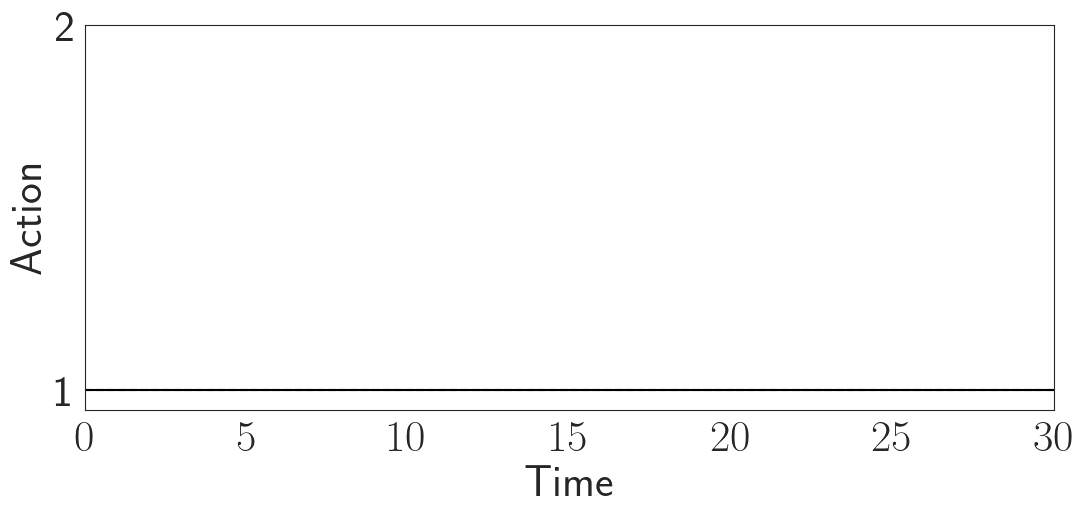

In [9]:
obs_dist = np.vstack([obs_dist[:,0],obs_dist[:,1:].sum(axis=1)]).T

sns.set_style("white")
plt.figure(figsize=(12.5,5))
### plot as staircase plot

plt.step(np.arange(80),actions_taken[0,5,0,:].T//5+1,label=f"$\pi_0(x=1)$ = {public_belief_grid[5]:0.2f}",color='black',linestyle='--')
plt.step(np.arange(80),actions_taken[0,10,0,:].T//5+1,label=f"$\pi_0(x=1)$ = {public_belief_grid[10]:0.2f}",color='black',linestyle='-')
# plt.legend(title= "Initial Public Prior",fontsize=32,title_fontsize=32)
plt.xlim([0,30])
plt.yticks([1,2],['1','2'],fontsize=32)
plt.xticks(fontsize=32)
plt.xlabel("Time",fontsize=32)
plt.ylabel("Action",fontsize=32)
plt.savefig("plots/actions_taken_2_nolegend.pdf",bbox_inches='tight')

plt.show()

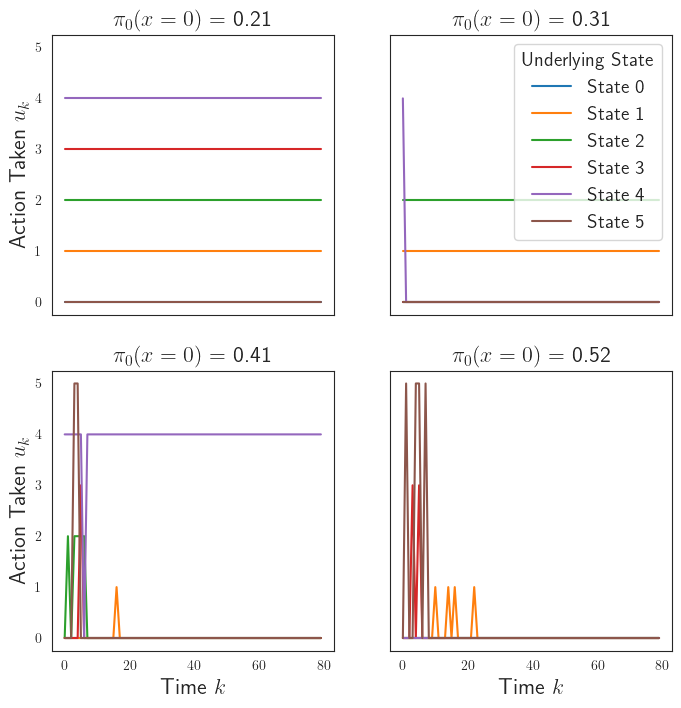

In [10]:

sns.set_style("white")
### add margins to the plots
fig, ax = plt.subplots(2,2,figsize=(8,8),sharex=True,sharey=True)
for i in range(6):
    ax[0,0].plot(actions_taken[0,6,i,:].flatten())
    ax[0,1].plot(actions_taken[0,9,i,:].flatten(),label=f"State {i}")
    ax[1,0].plot(actions_taken[0,12,i,:].flatten())
    ax[1,1].plot(actions_taken[0,15,i,:].flatten())
ax[0,1].legend(fontsize=14,title="Underlying State",title_fontsize=14,loc="upper right")
    
for i in range(4):
    public_grid_value = np.round(public_belief_grid[(6+3*i)],2)
    ax[i//2,i%2].set_title(f"$\pi_0(x=0)=$ {public_grid_value}",fontsize=16)
    # ax[i].set_xticklabels([0,20,40,60,80,100],fontsize=14)
ax[0,0].set_ylabel("Action Taken $u_k$",fontsize=16)
ax[1,0].set_ylabel("Action Taken $u_k$",fontsize=16)
ax[1,0].set_xlabel("Time $k$",fontsize=16)
ax[1,1].set_xlabel("Time $k$",fontsize=16)
plt.savefig("plots/action_value.pdf",bbox_inches="tight")
plt.show()

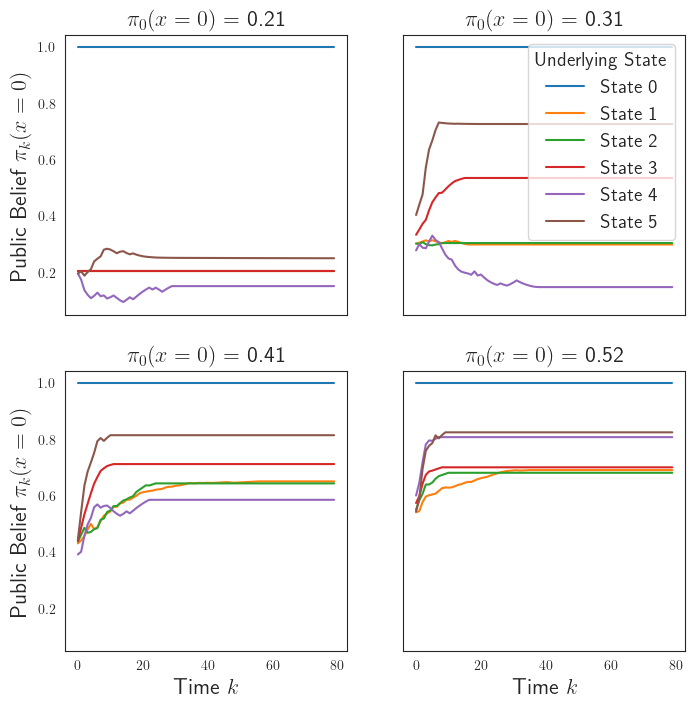

In [11]:
sns.set_style("white")
### add margins to th eplots
fig, ax = plt.subplots(2,2,figsize=(8,8),sharex=True,sharey=True)
for i in range(6):
    ax[0,0].plot(prior_value[:,6,i,:,0].mean(axis=0).flatten())
    ax[0,1].plot(prior_value[:,9,i,:,0].mean(axis=0).flatten(),label=f"State {i}")
    ax[1,0].plot(prior_value[:,12,i,:,0].mean(axis=0).flatten())
    ax[1,1].plot(prior_value[:,15,i,:,0].mean(axis=0).flatten())
ax[0,1].legend(fontsize=14,title="Underlying State",title_fontsize=14,loc="upper right")
    
for i in range(4):
    public_grid_value = np.round(public_belief_grid[(6+3*i)],2)
    ax[i//2,i%2].set_title(f"$\pi_0(x=0)=$ {public_grid_value}",fontsize=16)
    # ax[i].set_xticklabels([0,20,40,60,80,100],fontsize=14)
ax[0,0].set_ylabel("Public Belief $\pi_k(x=0)$",fontsize=16)
ax[1,0].set_ylabel("Public Belief $\pi_k(x=0)$",fontsize=16)
ax[1,0].set_xlabel("Time $k$",fontsize=16)
ax[1,1].set_xlabel("Time $k$",fontsize=16)
plt.savefig("plots/prior_value.pdf",bbox_inches="tight")
plt.show()

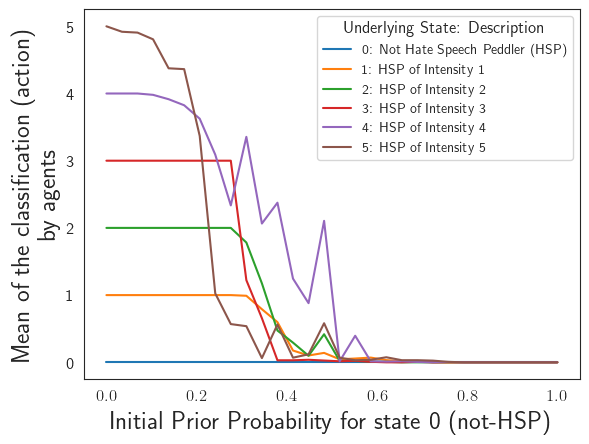

In [12]:
#### Public Belief Grid

labels = ["0: Not Hate Speech Peddler (HSP)","1: HSP of Intensity 1","2: HSP of Intensity 2","3: HSP of Intensity 3","4: HSP of Intensity 4","5: HSP of Intensity 5"]
labels_ticks = ["0","1","2","3","4","5"]
sns.axes_style("white")
import matplotlib.pyplot as plt
plt.plot(public_belief_grid,zero_counts,label=labels )
plt.xlabel("Initial Prior Probability for state 0 (not-HSP)",fontdict={"size":18})
plt.ylabel("Mean of the classification (action)\n by agents",fontdict={"size":18})
plt.yticks(Xs,labels_ticks,fontsize=12)
plt.xticks(fontsize=12)
plt.legend(title="Underlying State: Description",title_fontsize="large",fontsize="medium")
plt.savefig("plots/public_belief_grid.png")

In [ ]:
#### Simplex grid for X=3
import numpy as np

def generate_simplex_grid(num_points):
    # Create a grid for the simplex by generating points with step size
    step = 1.0 / num_points
    grid_points = []

    # Iterate over possible values of p1 and p2
    for i in range(num_points + 1):
        for j in range(num_points + 1 - i):
            p1 = i * step
            p2 = j * step
            p3 = 1 - p1 - p2
            grid_points.append([p1, p2, p3])

    return np.array(grid_points)

# Example usage
num_points = 50 # Defines the granularity of the grid
grid = generate_simplex_grid(num_points)
print(grid.shape)

In [ ]:
#### plot the grid
plt.scatter(grid[:,0],grid[:,1],c=grid[:,2],cmap="viridis")
plt.colorbar()


In [ ]:
##### 3x3 grid
X = 3
O = 3
A = 3
B = np.array([[0.6,0.2,0.2],[0.2,0.6,0.2],[0.2,0.2,0.6]])
state = 0

P = np.eye(X)
N_mc = 10
time_range = np.arange(10)
utility = np.array([[1,0,0],[0,1,0],[0,0,1]])
learning_or_not = np.zeros((N_mc,grid.shape[0]))
for i in tqdm.tqdm(range(grid.shape[0])):
    for j in range(N_mc):
        public_belief = grid[i,:]
        for t in time_range:
            ### sample an observation
            obs = np.random.choice(np.arange(3), p=B[state,:])    
            ### observation belief
            obs_prob = np.diag(B[:,obs])
            ### computing private belief
            private_belief = obs_prob @np.eye(X) @ public_belief
            normalization_factor = np.ones((1, O)) @ B.T @ P.T @ public_belief
            private_belief = private_belief / normalization_factor
            ### action selection
            action = np.argmax(utility.T @ private_belief)
            ### update public belief
            public_belief = T(public_belief,action,X,O,B,P,A,utility)
            public_belief = public_belief / np.sum(public_belief)
            ### update state
            state = np.random.choice(X, p=P[state,:])
            
        learning_or_not[j,i] = np.argmax(private_belief)
